In [1]:
from Model.Energy import GaussianEnergy
from Model.Proposal import GaussianProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy import MaxMinCensorship

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training data 

In [9]:
target_distribution = torch.distributions.Normal(torch.tensor([0,0], dtype=torch.float32) , torch.tensor([4,2], dtype=torch.float32))


In [10]:
sample_target_cartesian = target_distribution.sample((20000,))
# Select only the samples that are in the first quadrant
sample_target_cartesian[...,0] = torch.where(sample_target_cartesian[...,0] > -1, sample_target_cartesian[...,0], torch.full_like(sample_target_cartesian[...,0], torch.tensor(-1)))




dataset_total = TensorDataset(sample_target_cartesian, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000,])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

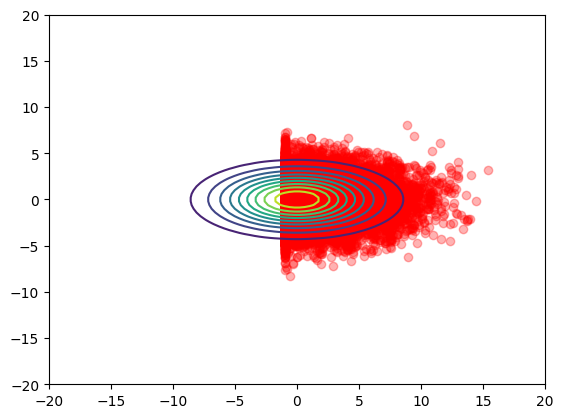

In [11]:


fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = target_distribution.log_prob(torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)).sum(-1).exp().numpy()

ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_target_cartesian[...,0], sample_target_cartesian[...,1], color='r', alpha=0.3)

# Proposal

In [12]:
proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))

Init Standard Gaussian...


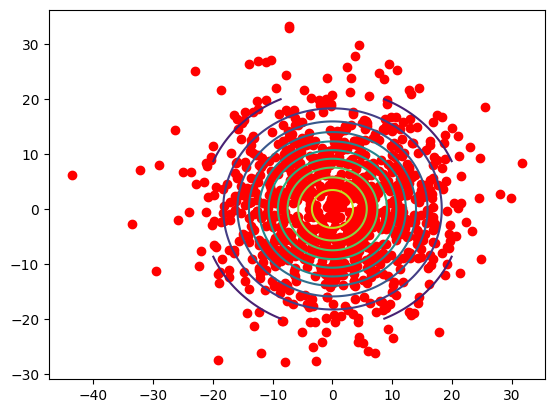

In [13]:
sample_proposal = proposal_distribution.sample(1000,)

fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)
Z = proposal_distribution.log_prob(input_grid.flatten(0,1)).exp().numpy().reshape(X.shape)
ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_proposal[...,0], sample_proposal[...,1], color='r')

# Energy

In [14]:
energy = GaussianEnergy(dim=2, learn_mu=True, learn_sigma=True)
energy.set_censoring(MaxMinCensorship(min = torch.tensor([-1,-20], dtype=torch.float32), max= torch.tensor([20,20], dtype=torch.float32)))

In [15]:
print(energy(x=sample_target_cartesian))
print(energy(x=sample_proposal))

tensor([10.3739, 15.3981,  1.3819,  ...,  2.4128,  3.5371,  1.2484],
       grad_fn=<MulBackward0>)
tensor([2.5636e+01, 7.8678e+01, 1.2830e+01, 1.2067e+02, 1.7782e+02, 2.6762e+01,
        1.3915e+02, 1.5579e+01, 6.1087e+01, 1.2529e+02, 5.2056e+00, 2.3076e+02,
        3.5203e+01, 1.4008e+02, 7.9950e+01, 2.5881e+00, 2.2482e-01, 5.2086e+01,
        2.1048e+01, 1.4463e+02, 4.2530e+00, 1.0705e+02, 4.2254e+01, 1.4683e+02,
        2.6881e+02, 3.1880e+01, 6.7583e+01, 2.0050e+02, 5.1943e+01, 2.0337e+02,
        5.6051e+01, 5.8451e+01, 9.0460e+00, 1.9770e+02, 9.3321e+01, 2.2382e+01,
        7.1689e+01, 1.9937e+01, 2.7591e+01, 1.6240e+02, 2.1925e+02, 9.9730e+01,
        5.0025e-01, 1.0174e+02, 1.8649e+00, 1.7115e+02, 8.5075e+01, 3.6745e+01,
        1.2560e+02, 2.0050e+02, 1.3968e+02, 8.7825e+01, 2.7235e+02, 4.4436e+01,
        6.6441e+00, 8.2878e+01, 7.7097e+01, 9.3430e+01, 1.1124e+02, 1.1839e+02,
        5.6571e+00, 9.4179e+01, 6.5706e+01, 6.3100e+00, 1.2409e+02, 3.1567e+01,
        4.4023e+01, 

# Trainer :


In [16]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


In [17]:
trainer.train(n_iter=200_000, n_iter_pretrain=100,)